In [174]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from shutil import copyfile, rmtree
import zipfile
import pandas as pd
import numpy as np
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import matplotlib.pyplot as plt
import tensorflow as tf
import string
import random
import os
import math
from timeit import default_timer as timer
from tqdm import tqdm, trange, tqdm_notebook
from sklearn.preprocessing import LabelBinarizer

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Prepare Data

In [6]:
dataset_zip_file = 'sign-language-mnist'

In [7]:
with zipfile.ZipFile(f"./{dataset_zip_file}.zip","r") as z:
    z.extractall(f"./{dataset_zip_file}/")

In [122]:
test_df = pd.read_csv(f'./{dataset_zip_file}/sign_mnist_test.csv')
test_df

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,6,149,149,150,150,150,151,151,150,151,...,138,148,127,89,82,96,106,112,120,107
1,5,126,128,131,132,133,134,135,135,136,...,47,104,194,183,186,184,184,184,182,180
2,10,85,88,92,96,105,123,135,143,147,...,68,166,242,227,230,227,226,225,224,222
3,0,203,205,207,206,207,209,210,209,210,...,154,248,247,248,253,236,230,240,253,255
4,3,188,191,193,195,199,201,202,203,203,...,26,40,64,48,29,46,49,46,46,53
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7167,1,135,119,108,102,105,99,61,103,121,...,108,112,116,114,118,180,184,176,167,163
7168,12,157,159,161,164,166,166,171,174,175,...,213,213,213,214,213,211,210,210,209,208
7169,2,190,191,190,191,190,190,192,192,191,...,216,215,213,214,214,213,210,211,209,208
7170,4,201,205,208,209,214,216,218,223,226,...,112,169,255,255,237,113,91,67,70,63


In [159]:
train_df = pd.read_csv(f'./{dataset_zip_file}/sign_mnist_train.csv')
train_df

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27450,13,189,189,190,190,192,193,193,193,193,...,132,165,99,77,52,200,234,200,222,225
27451,23,151,154,157,158,160,161,163,164,166,...,198,198,198,198,198,196,195,195,195,194
27452,18,174,174,174,174,174,175,175,174,173,...,121,196,209,208,206,204,203,202,200,200
27453,17,177,181,184,185,187,189,190,191,191,...,119,56,27,58,102,79,47,64,87,93


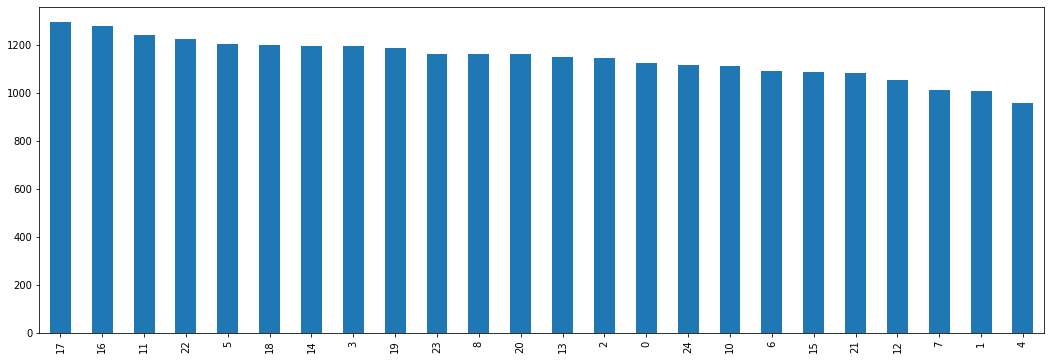

In [160]:
plt.figure(figsize = (18, 6))
train_df['label'].value_counts().plot.bar()

In [161]:
train_df['label'].value_counts()

17    1294
16    1279
11    1241
22    1225
5     1204
18    1199
14    1196
3     1196
19    1186
23    1164
8     1162
20    1161
13    1151
2     1144
0     1126
24    1118
10    1114
6     1090
15    1088
21    1082
12    1055
7     1013
1     1010
4      957
Name: label, dtype: int64

In [162]:
max_samples = train_df['label'].value_counts().max()
max_samples

1294

In [163]:
labels = train_df['label'].unique()

In [164]:
img_oversample = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
)

augmented_images = []
for i in labels:
    lack = max_samples - len(train_df[train_df['label'] == i])
    print(i, lack)
    if lack == 0:
        continue
    vals = train_df[train_df['label'] == i].values
    vals = np.delete(vals, 0, axis=1)
    
    to_aug_idx = np.random.choice(len(vals), lack)
    img_to_aug = vals[to_aug_idx]
    
    for img in img_to_aug:
        new_img_iter = img_oversample.flow(img_to_aug[0].reshape(1, 28, 28, 1), y=[i], batch_size=1)
        new_img = new_img_iter.next()[0].reshape(784)
        augmented_images.append(
            pd.Series(np.hstack([i, new_img]), index=train_df.columns)
        )



3 98
6 204
2 150
13 143
16 15
8 132
22 69
18 95
10 180
20 133
17 0
19 108
21 212
23 130
24 176
1 284
12 239
11 53
15 206
4 337
0 168
5 90
7 281
14 98


In [165]:
aug_train_df = train_df.append(augmented_images).astype({'label': 'int32'})
aug_train_df

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107.000000,118.000000,127.000000,134.000000,139.000000,143.000000,146.000000,150.000000,153.000000,...,207.000000,207.000000,207.000000,207.000000,206.000000,206.000000,206.000000,204.000000,203.000000,202.000000
1,6,155.000000,157.000000,156.000000,156.000000,156.000000,157.000000,156.000000,158.000000,158.000000,...,69.000000,149.000000,128.000000,87.000000,94.000000,163.000000,175.000000,103.000000,135.000000,149.000000
2,2,187.000000,188.000000,188.000000,187.000000,187.000000,186.000000,187.000000,188.000000,187.000000,...,202.000000,201.000000,200.000000,199.000000,198.000000,199.000000,198.000000,195.000000,194.000000,195.000000
3,2,211.000000,211.000000,212.000000,212.000000,211.000000,210.000000,211.000000,210.000000,210.000000,...,235.000000,234.000000,233.000000,231.000000,230.000000,226.000000,225.000000,222.000000,229.000000,163.000000
4,13,164.000000,167.000000,170.000000,172.000000,176.000000,179.000000,180.000000,184.000000,185.000000,...,92.000000,105.000000,105.000000,108.000000,133.000000,163.000000,157.000000,163.000000,164.000000,179.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3596,14,155.408264,157.286743,159.165207,161.021835,161.961075,164.720154,165.859894,167.146622,168.409027,...,192.848907,193.000000,193.000000,192.333389,192.000000,191.454910,191.484314,191.576447,191.000000,191.000000
3597,14,147.043518,146.462463,146.000000,146.000000,146.909607,149.680054,151.753693,153.413666,154.450500,...,189.782852,189.316498,188.749878,187.673431,187.852676,187.878296,187.587769,187.297241,187.006714,187.000000
3598,14,153.290558,154.202896,155.230453,157.055115,158.879791,160.704453,161.764557,164.030670,165.589218,...,189.773026,191.329422,191.567078,192.000000,191.993881,192.042831,192.155090,191.221512,190.720016,190.177902
3599,14,154.354568,155.489517,157.269897,159.050293,160.830673,161.805527,164.087173,165.585922,166.476105,...,125.923462,120.356033,158.755234,188.050262,191.004181,191.728592,192.230713,192.627960,192.883087,192.960007


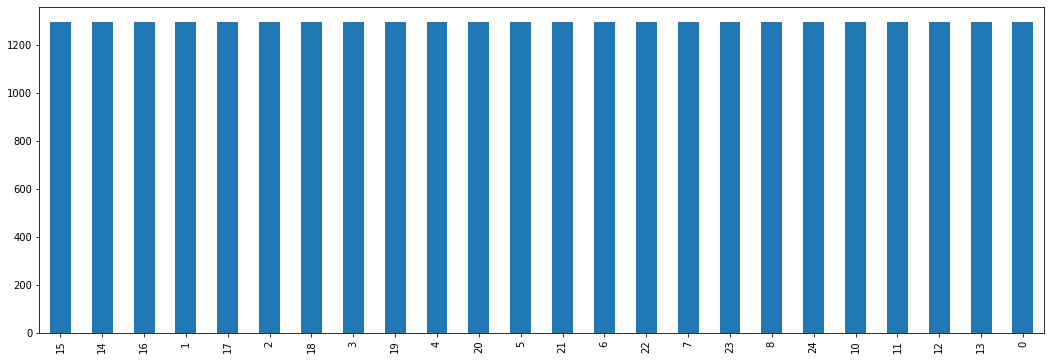

In [166]:
plt.figure(figsize = (18, 6))
aug_train_df['label'].value_counts().plot.bar()

In [167]:
aug_train_df, aug_valid_df = train_test_split(aug_train_df, test_size=0.25, random_state=42, stratify=aug_train_df['label'])

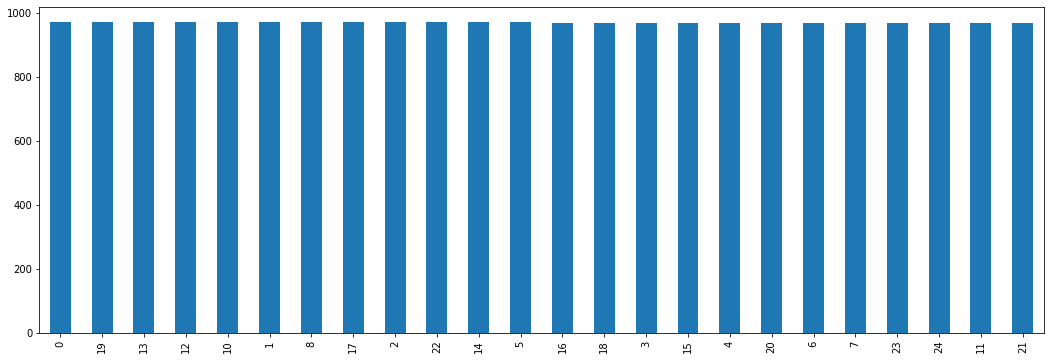

In [170]:
plt.figure(figsize = (18, 6))
aug_train_df['label'].value_counts().plot.bar()

In [169]:
aug_valid_df

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
25614,1,183.000000,183.000000,185.00000,185.000000,187.000000,186.000000,185.000000,185.000000,185.000000,...,134.000000,211.000000,151.000000,83.000000,48.000000,41.000000,42.000000,44.000000,47.000000,50.000000
23125,11,117.000000,119.000000,123.00000,124.000000,125.000000,128.000000,130.000000,131.000000,132.000000,...,162.000000,163.000000,162.000000,160.000000,161.000000,160.000000,159.000000,159.000000,159.000000,159.000000
18430,15,96.000000,97.000000,99.00000,100.000000,104.000000,114.000000,124.000000,136.000000,143.000000,...,135.000000,124.000000,191.000000,210.000000,196.000000,189.000000,173.000000,138.000000,109.000000,110.000000
3127,1,122.000000,125.000000,129.00000,132.000000,136.000000,138.000000,138.000000,139.000000,139.000000,...,221.000000,218.000000,219.000000,218.000000,217.000000,219.000000,218.000000,218.000000,217.000000,216.000000
2157,12,164.999664,164.184509,163.36937,163.000000,165.492783,168.232376,170.386597,172.763031,176.065109,...,65.816101,58.090912,40.541698,38.124767,52.105412,62.310425,59.732319,57.015171,54.298019,51.580872
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
559,13,227.971863,227.806091,227.64032,227.474548,227.927475,229.315979,229.108978,230.071854,232.245117,...,255.000000,255.000000,255.000000,255.000000,254.318497,252.435410,250.552307,248.733063,247.098129,246.000000
16024,24,191.000000,192.000000,193.00000,194.000000,193.000000,194.000000,194.000000,194.000000,195.000000,...,112.000000,134.000000,177.000000,189.000000,174.000000,130.000000,163.000000,177.000000,200.000000,207.000000
17001,0,191.000000,192.000000,193.00000,193.000000,194.000000,195.000000,196.000000,195.000000,195.000000,...,132.000000,207.000000,227.000000,231.000000,232.000000,220.000000,215.000000,221.000000,229.000000,228.000000
26661,3,58.000000,71.000000,92.00000,104.000000,109.000000,115.000000,122.000000,127.000000,130.000000,...,15.000000,6.000000,0.000000,18.000000,17.000000,0.000000,0.000000,24.000000,22.000000,14.000000


In [206]:
label_binrizer = LabelBinarizer()

def df_to_x_y(df):
    
    y = label_binrizer.fit_transform(np.array(df['label']))
    
    x_df = df.drop('label', axis = 1)
    x = np.array(x_df).reshape(-1, 28, 28, 1)
    
    return x, y

In [207]:
train_x, train_y = df_to_x_y(aug_train_df)
train_x.shape, train_y.shape

((23292, 28, 28, 1), (23292, 24))

In [208]:
valid_x, valid_y = df_to_x_y(aug_valid_df)
valid_x.shape, valid_y.shape

((7764, 28, 28, 1), (7764, 24))

In [209]:
test_x, test_y = df_to_x_y(test_df)
test_x.shape, test_y.shape

((7172, 28, 28, 1), (7172, 24))

# Train Models

In [187]:
def plot_curves(title, data, y_title, x_title='Epoch', legend=[], x_labels_offset = 0):
    fig = plt.figure(figsize=(8, 4))
        
    for row in data:
        x = range(x_labels_offset, len(row))
        plt.plot(x, row[x_labels_offset:])
    
    plt.title(title)
    plt.ylabel(y_title)
    plt.xlabel(x_title)
    plt.grid(True)
    plt.legend(legend, loc='upper left')
    plt.show()

In [210]:
WIDTH = 28
HEIGHT = 28
IMG_SIZE = (WIDTH, HEIGHT)
CHANNELS = 1
OUTPUT = 24

In [219]:
class BaseModel():
    def __init__(self, drop_out=0.15):
        self.init_basic_params(drop_out)
        
        self.compile()
        
        self.tf_writer.add_graph(self.session.graph)
    
    def rand_str(self, str_len=20):
        return ''.join(random.choices(string.ascii_uppercase + string.digits, k=str_len))
    
    def init_basic_params(self, drop_out):
        tf.reset_default_graph()
        self.logs_path = './tf_board/' + self.__class__.__name__
        self.var_scope = self.rand_str()
        self.print_separator = '-' * 65
        self.session = None
        self.dropout_rate_tf = tf.placeholder(tf.float32)
        self.dropout_rate_tf_cnn = tf.placeholder(tf.float32)
        
        self.input_size = [WIDTH, HEIGHT, CHANNELS]
        self.output_size = OUTPUT
        
        self.dropout_rate = drop_out
        self.dropout_rate_cnn = 0.0
        
        self.start_learning_rate = 0.01
        
        self.tf_writer = tf.summary.FileWriter(self.logs_path)
    
    def __del__(self): 
        print('object del')
        if self.session:
            tf.reset_default_graph()
            self.session.close()
    
    def reset_internal_params(self):
        self.hidden_layers = {}
        self.hidden_layers_W = {}
        self.hidden_layers_b = {}
        self.history = {
            'acc_train': [],
            'acc_valid': [],
            'loss_train': [],
            'loss_valid': []
        }
        
        self.global_step = tf.Variable(0, trainable=False)
        self.decay_steps = tf.Variable(100000, trainable=False)
    
    def get_W(self, layer_id, shape):
        #with tf.variable_scope(self.var_scope, reuse=tf.AUTO_REUSE):
        #W = tf.Variable(tf.truncated_normal(shape, stddev=0.1, mean=0), name=f'W_{layer_id}')
        initializer = tf.contrib.layers.variance_scaling_initializer()
        W = tf.Variable(initializer(shape), name=f'W_{layer_id}')
        self.hidden_layers_W[layer_id] = W

        return self.hidden_layers_W[layer_id]

    def get_b(self, layer_id, shape):
        #with tf.variable_scope(self.var_scope, reuse=tf.AUTO_REUSE):
        self.hidden_layers_b[layer_id] = tf.Variable(tf.zeros(shape), name=f'b_{layer_id}')
        
        return self.hidden_layers_b[layer_id]
        
    def get_dense_layer(self, layer_id, prev_layer, units_count, activ=tf.nn.relu):
        input_size = prev_layer.get_shape().as_list()[1]
        
        W = self.get_W(layer_id, [input_size, units_count])
        b = self.get_b(layer_id, [units_count])
        
        layer = tf.matmul(prev_layer, W) + b
        
        if activ:
            layer = activ(layer, name=f'Lay_Dense_{layer_id}')
        
        return layer
    
    def get_conv2_layer(self, layer_id, prev_layer, kernel_size, output_channels, strides=1, padding='SAME', activ=tf.nn.relu):
        input_channels = prev_layer.get_shape().as_list()[3]
        
        # 5x5 conv, 1 input, 32 outputs
        # [filter_height, filter_width, in_channels, out_channels]
        filter_shape = [kernel_size[0], kernel_size[1], input_channels, output_channels]

        W = self.get_W(layer_id, filter_shape)
        b = self.get_b(layer_id, [output_channels])
        
        layer = tf.nn.conv2d(prev_layer, W, [1, strides, strides, 1], padding) + b
        
        if activ:
            layer = activ(layer, name=f'Lay_Conv2d_{layer_id}')  
        
        return layer
    
    def flatten(self, input):
        shape = input.get_shape().as_list()
        shape = np.array(shape)
        size = shape[shape != None].prod()
        
        return tf.reshape(input, [-1, size], name='Flatten')
    
    def batch_norm(self, input):
        #return tf.contrib.layers.batch_norm(input, fused=True, data_format='NCHW')
        return tf.contrib.layers.batch_norm(input)
    
    def get_max_pooling(self, layer_id, input, ksize, stride=1, padding='SAME'):
        return tf.nn.max_pool(input, [1, ksize, ksize, 1], [1, stride, stride, 1], padding, name=f'max_pool_{layer_id}')

    def get_avg_pooling(self, layer_id, input, ksize, stride=1, padding='SAME'):
        return tf.nn.avg_pool(input, [1, ksize, ksize, 1], [1, stride, stride, 1], padding, name=f'avg_pool_{layer_id}')
    
    def pre_compile():
        print('precompile')
    
    def next_batch(self, x, y, batch_size, iteration):
        start = iteration * batch_size
        end = (iteration + 1) * batch_size
        
        return x[start:end], y[start:end]
    
    def l2_reg(self, loss_rate=0.01):
        reg_sum = 0
        for key in self.hidden_layers_W:
            reg_sum += tf.nn.l2_loss(self.hidden_layers_W[key])
        
        return loss_rate * reg_sum
    
    def compile(self):
        
        self.lr = tf.placeholder(tf.float32, shape=[])
        
        self.pre_compile()
        
        self.prediction_proba = tf.nn.softmax(self.layer_output, name='Output')
        self.prediction = tf.round(self.prediction_proba)
        
        #self.accuracy = tf.reduce_mean(
        #    tf.cast(
        #        tf.equal(tf.argmax(self.prediction, 1), tf.argmax(self.expected_output, 1)),
        #        tf.float32,
        #    ),
        #    name='Accuracy'
        #)
        
        self.accuracy = tf.reduce_mean(
            tf.cast(
                tf.equal(tf.argmax(self.prediction, 1), tf.argmax(self.expected_output, 1)),
                tf.float32
            ),
            name='Accuracy'
        )
                
        self.session = tf.Session()
        self.vars = tf.global_variables_initializer()
        self.session.run(tf.global_variables_initializer())
    
    def fit_gen(self, train_gen, valid_gen=None, epochs=1):
        
        fit_start = timer()
        
        iterations = train_gen.__len__()
        batch_size = train_gen.batch_size
            
        print(self.print_separator)
        print(f'Epochs: {epochs}\t| Iterations: {iterations}\t| Batch: {batch_size}')
        print(self.print_separator)
        
        for epoch in range(epochs):
            
            start = timer()
            loss_train = 0
            acc_train = 0
            
            with trange(iterations) as t:
                for iteration in t:
                    x_batch, y_batch = train_gen.__getitem__(iteration)
                    
                    #loss_container = []
                    #acc_container = []
                    
                    feed_data = { 
                        self.input: x_batch, 
                        self.expected_output: y_batch.reshape([-1, self.output_size]),
                        self.dropout_rate_tf: self.dropout_rate,
                        self.dropout_rate_tf_cnn: self.dropout_rate_cnn
                    }

                    self.session.run(self.optimizer, feed_dict=feed_data)


                    feed_data_metrics = { 
                        self.input: x_batch, 
                        self.expected_output: y_batch.reshape([-1, self.output_size]),
                        self.dropout_rate_tf: 0,
                        self.dropout_rate_tf_cnn: 0
                    }

                    loss, acc = self.session.run([self.loss, self.accuracy], feed_dict=feed_data_metrics)

                    #loss_container.append(loss)
                    #acc_container.append(acc)
                    
                    loss_train += loss / iterations
                    acc_train += acc / iterations
                    #loss_train = np.mean(loss_container)
                    #acc_train = np.mean(acc_container)
                    
                    t.set_description(f'Epoch: {epoch + 1}')

                    t.set_postfix(loss=f'{loss_train:.5f}', acc=f'{acc_train:.02%}')

                    #if iteration % 20 == 0 and iteration > 0:
                    #    print(f'iteration: {iteration}')
                

            #loss_train, acc_train = self.evaluate_gen(train_gen)
        
            self.history['loss_train'].append(loss_train)            
            self.history['acc_train'].append(acc_train)
            
            
            if valid_gen != None:
                loss_valid, acc_valid = self.evaluate_gen(valid_gen)
        
                self.history['loss_valid'].append(loss_valid)
                self.history['acc_valid'].append(acc_valid)
            
            end = timer()
            
            epoch_time = end - start
            
            if valid_gen != None:
                print(f'Epoch {epoch + 1}: ({epoch_time:.5f} s) \t loss - Tr[{loss_train:.5f}] Va[{loss_valid:.5f}] \t acc - Tr[{acc_train:.02%}] Va[{acc_valid:.02%}]')
            else:
                print(f'Epoch {epoch + 1}: ({epoch_time:.5f} s) \t loss - Tr[{loss_train:.5f}] \t acc - Tr[{acc_train:.02%}]')
                
            print(self.print_separator)
        
        fit_end = timer()
        
        epoch_time = fit_end - fit_start
        print(f'Finished in: {epoch_time:.4f} s')
        
    def evaluate_gen(self, eval_gen):
        loss = 0
        acc = 0

        iterations = eval_gen.__len__()
        
        for iteration in range(iterations):
            x_batch, y_batch = eval_gen.__getitem__(iteration)
            feed_data = { 
                    self.input: x_batch, 
                    self.expected_output: y_batch.reshape([-1, self.output_size]),
                    self.dropout_rate_tf: 0,
                    self.dropout_rate_tf_cnn: 0
                }
                
            batch_loss, batch_acc = self.session.run([self.loss, self.accuracy], feed_dict=feed_data)
            
            acc += batch_acc / iterations
            loss += batch_loss / iterations
                
        return loss, acc 
    
    def evaluate(self, x=None, y=None):
        feed_data = { self.input: x, self.expected_output: y, self.dropout_rate_tf: 0, self.dropout_rate_tf_cnn: 0}
        return self.session.run([self.loss, self.accuracy], feed_dict=feed_data)
    
    def predict(self, x, batch_size=None):
        if batch_size is None:
            feed_data = { self.input: x, self.dropout_rate_tf: 0}
            return self.session.run(self.prediction, feed_dict=feed_data)
        
        

    def predict_proba(self, x, batch_size=None):
        if batch_size is None:
            feed_data = { self.input: x, self.dropout_rate_tf: 0, self.dropout_rate_tf_cnn: 0}
            return self.session.run(self.prediction_proba, feed_dict=feed_data)
        
        output = []
        
        iterations = math.ceil(len(x) / batch_size)
        for iteration in range(iterations):
            x_batch, _ = self.next_batch(x, x, batch_size, iteration)
            feed_data = { self.input: x_batch, self.dropout_rate_tf: 0, self.dropout_rate_tf_cnn: 0}
            result = self.session.run(self.prediction_proba, feed_dict=feed_data)
            output.append(result)
        
        return np.vstack(output)
    

In [220]:
class Model1(BaseModel):
    def __init__(self, drop_out=0.15):
        BaseModel.__init__(self, drop_out)

    def init_basic_params(self, drop_out):
        super().init_basic_params(drop_out)
        
        self.start_learning_rate = 0.001
        
    def pre_compile(self):
        self.reset_internal_params()

        self.input = tf.placeholder(tf.float32, shape=[None, *self.input_size], name="Input")
        self.expected_output = tf.placeholder(tf.float32, shape=[None, self.output_size], name="Y_actual")
   
        out = self.get_conv2_layer(1, self.input, [4, 4], 32)
        out = self.batch_norm(out)
        out = self.get_max_pooling(2, out, 2, stride=2)
        out = tf.nn.dropout(out, rate=self.dropout_rate_tf_cnn)
    
        out = self.get_conv2_layer(3, out, [4, 4], 64)
        out = self.batch_norm(out)
        out = self.get_max_pooling(4, out, 2, stride=2)
        out = tf.nn.dropout(out, rate=self.dropout_rate_tf_cnn)
        
        
        out = self.get_conv2_layer(7, out, [4, 4], 128)
        out = self.batch_norm(out)
        out = self.get_max_pooling(8, out, 2, stride=2)
        
        #out = tf.nn.dropout(out, rate=self.dropout_rate_tf_cnn)
        
        #out = self.get_conv2_layer(9, out, [1, 1], 256)
        
        #out = tf.nn.dropout(out, rate=self.dropout_rate_tf_cnn)
        #out = self.get_conv2_layer(7, out, [5, 5], 256)
        #out = self.batch_norm(out)
        #out = self.get_max_pooling(8, out, 2, stride=2)
        
        #out = tf.nn.dropout(out, rate=self.dropout_rate_tf_cnn)
        #out = self.get_conv2_layer(9, out, [1, 1], 512)

        out = self.flatten(out)
        
        #out = tf.nn.dropout(out, rate=self.dropout_rate_tf)

        out = self.get_dense_layer(10, out, 128)
        
        out = tf.nn.dropout(out, rate=self.dropout_rate_tf)

        out = self.get_dense_layer(11, out, 128)
        
        out = tf.nn.dropout(out, rate=self.dropout_rate_tf)
        
        out = self.get_dense_layer(12, out, self.output_size, activ=None)

        self.layer_output = out
        
        self.loss = tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits_v2(labels=self.expected_output, logits=self.layer_output),
            name='Loss'
        ) #+ self.l2_reg(loss_rate=0.001)
        
        #self.optimizer = tf.train.RMSPropOptimizer(self.start_learning_rate).minimize(self.loss, global_step=self.global_step)
        self.optimizer = tf.train.AdamOptimizer(self.start_learning_rate).minimize(self.loss, global_step=self.global_step)

In [317]:
BATCH_SIZE=64
VALID_BATCH_SIZE=512
EPOCH=30
TR_LAERN_EPOCH = 15

In [318]:
o_data_gen = ImageDataGenerator(rescale=1.0/255.0)

o_train_gen = o_data_gen.flow(x=train_x, y=train_y, batch_size=BATCH_SIZE, shuffle=True)
o_valid_gen = o_data_gen.flow(x=valid_x, y=valid_y, batch_size=VALID_BATCH_SIZE, shuffle=True)
o_test_gen = o_data_gen.flow(x=test_x, y=test_y, batch_size=VALID_BATCH_SIZE, shuffle=True)


In [319]:
def print_test(title, model):
    orig_test_loss, orig_test_acc = model.evaluate_gen(o_test_gen)

    print(f'{title}: loss - {orig_test_loss:.4f}\t Acc - {orig_test_acc:.02%}')

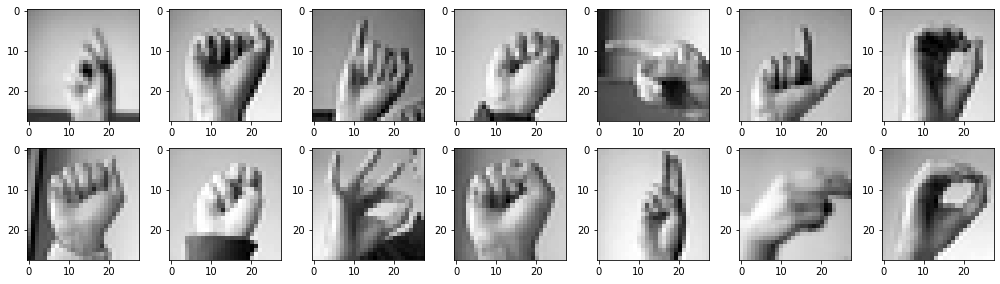

In [320]:
plt.figure(figsize=(14, 4))
for i in range(0, 14):
    plt.subplot(2, 7, i+1)
    for X_batch, Y_batch in o_train_gen:
        image = X_batch[0]
        plt.imshow(image.reshape(28, 28), cmap='gray')
        break
plt.tight_layout()
plt.show()

In [321]:
orig_model_1 = Model1(drop_out=0.5)
orig_model_1.fit_gen(o_train_gen, o_valid_gen, epochs=EPOCH)

  0%|          | 0/364 [00:00<?, ?it/s]

object del
-----------------------------------------------------------------
Epochs: 30	| Iterations: 364	| Batch: 64
-----------------------------------------------------------------


  0%|          | 0/364 [00:00<?, ?it/s]

Epoch 1: (79.41480 s) 	 loss - Tr[2.80019] Va[2.45577] 	 acc - Tr[6.89%] Va[10.95%]
-----------------------------------------------------------------


  0%|          | 0/364 [00:00<?, ?it/s]

Epoch 2: (79.48065 s) 	 loss - Tr[2.21843] Va[1.99013] 	 acc - Tr[12.51%] Va[13.23%]
-----------------------------------------------------------------


  0%|          | 0/364 [00:00<?, ?it/s]

Epoch 3: (78.22236 s) 	 loss - Tr[1.88720] Va[1.66704] 	 acc - Tr[17.84%] Va[26.32%]
-----------------------------------------------------------------


  0%|          | 0/364 [00:00<?, ?it/s]

Epoch 4: (77.88566 s) 	 loss - Tr[1.48580] Va[1.32597] 	 acc - Tr[31.80%] Va[35.12%]
-----------------------------------------------------------------


  0%|          | 0/364 [00:00<?, ?it/s]

Epoch 5: (78.13804 s) 	 loss - Tr[1.12156] Va[0.90560] 	 acc - Tr[39.07%] Va[44.47%]
-----------------------------------------------------------------


  0%|          | 0/364 [00:00<?, ?it/s]

Epoch 6: (81.71772 s) 	 loss - Tr[0.81973] Va[0.75797] 	 acc - Tr[48.50%] Va[52.21%]
-----------------------------------------------------------------


  0%|          | 0/364 [00:00<?, ?it/s]

Epoch 7: (77.52533 s) 	 loss - Tr[0.66107] Va[0.58201] 	 acc - Tr[59.01%] Va[67.36%]
-----------------------------------------------------------------


  0%|          | 0/364 [00:00<?, ?it/s]

Epoch 8: (77.54517 s) 	 loss - Tr[0.52299] Va[0.47248] 	 acc - Tr[71.54%] Va[79.57%]
-----------------------------------------------------------------


  0%|          | 0/364 [00:00<?, ?it/s]

Epoch 9: (78.83923 s) 	 loss - Tr[0.43896] Va[0.39141] 	 acc - Tr[80.46%] Va[83.83%]
-----------------------------------------------------------------


  0%|          | 0/364 [00:00<?, ?it/s]

Epoch 10: (84.78435 s) 	 loss - Tr[0.38208] Va[0.39900] 	 acc - Tr[83.78%] Va[81.94%]
-----------------------------------------------------------------


  0%|          | 0/364 [00:00<?, ?it/s]

Epoch 11: (82.75257 s) 	 loss - Tr[0.34365] Va[0.35993] 	 acc - Tr[85.25%] Va[83.57%]
-----------------------------------------------------------------


  0%|          | 0/364 [00:00<?, ?it/s]

Epoch 12: (80.77545 s) 	 loss - Tr[0.31728] Va[0.31163] 	 acc - Tr[85.86%] Va[86.37%]
-----------------------------------------------------------------


  0%|          | 0/364 [00:00<?, ?it/s]

Epoch 13: (84.65780 s) 	 loss - Tr[0.30360] Va[0.30074] 	 acc - Tr[86.12%] Va[86.21%]
-----------------------------------------------------------------


  0%|          | 0/364 [00:00<?, ?it/s]

Epoch 14: (82.82241 s) 	 loss - Tr[0.28284] Va[0.28324] 	 acc - Tr[86.45%] Va[86.56%]
-----------------------------------------------------------------


  0%|          | 0/364 [00:00<?, ?it/s]

Epoch 15: (83.20263 s) 	 loss - Tr[0.27032] Va[0.26929] 	 acc - Tr[86.67%] Va[86.54%]
-----------------------------------------------------------------


Epoch: 17:   0%|          | 1/364 [00:00<01:09,  5.24it/s, acc=0.21%, loss=0.00110]

Epoch 16: (77.97211 s) 	 loss - Tr[0.25754] Va[0.25077] 	 acc - Tr[86.76%] Va[87.15%]
-----------------------------------------------------------------


  0%|          | 0/364 [00:00<?, ?it/s]

Epoch 17: (75.32632 s) 	 loss - Tr[0.25143] Va[0.27677] 	 acc - Tr[86.80%] Va[85.55%]
-----------------------------------------------------------------


Epoch: 19:   0%|          | 0/364 [00:00<?, ?it/s]

Epoch 18: (75.39854 s) 	 loss - Tr[0.24165] Va[0.23924] 	 acc - Tr[87.07%] Va[87.12%]
-----------------------------------------------------------------


Epoch: 20:   0%|          | 1/364 [00:00<01:11,  5.07it/s, acc=0.21%, loss=0.00101]

Epoch 19: (75.52922 s) 	 loss - Tr[0.23577] Va[0.22499] 	 acc - Tr[87.10%] Va[87.41%]
-----------------------------------------------------------------


Epoch: 21:   0%|          | 1/364 [00:00<01:08,  5.32it/s, acc=0.21%, loss=0.00103]

Epoch 20: (74.95047 s) 	 loss - Tr[0.22825] Va[0.23121] 	 acc - Tr[87.25%] Va[87.21%]
-----------------------------------------------------------------


  0%|          | 0/364 [00:00<?, ?it/s]

Epoch 21: (79.18384 s) 	 loss - Tr[0.22907] Va[0.22900] 	 acc - Tr[87.15%] Va[87.25%]
-----------------------------------------------------------------


Epoch: 23:   0%|          | 0/364 [00:00<?, ?it/s]

Epoch 22: (75.37014 s) 	 loss - Tr[0.22173] Va[0.21351] 	 acc - Tr[87.18%] Va[87.43%]
-----------------------------------------------------------------


Epoch: 24:   0%|          | 0/364 [00:00<?, ?it/s]

Epoch 23: (76.05602 s) 	 loss - Tr[0.21196] Va[0.20915] 	 acc - Tr[87.33%] Va[87.39%]
-----------------------------------------------------------------


  0%|          | 0/364 [00:00<?, ?it/s]

Epoch 24: (76.25598 s) 	 loss - Tr[0.20637] Va[0.20408] 	 acc - Tr[87.26%] Va[87.50%]
-----------------------------------------------------------------


Epoch: 26:   0%|          | 0/364 [00:00<?, ?it/s]

Epoch 25: (77.84959 s) 	 loss - Tr[0.20571] Va[0.20229] 	 acc - Tr[87.26%] Va[87.44%]
-----------------------------------------------------------------


  0%|          | 0/364 [00:00<?, ?it/s]

Epoch 26: (76.18086 s) 	 loss - Tr[0.20926] Va[0.21120] 	 acc - Tr[87.25%] Va[87.32%]
-----------------------------------------------------------------


Epoch: 28:   0%|          | 1/364 [00:00<01:09,  5.25it/s, acc=0.21%, loss=0.00090]

Epoch 27: (75.72524 s) 	 loss - Tr[0.19925] Va[0.20070] 	 acc - Tr[87.40%] Va[87.39%]
-----------------------------------------------------------------


Epoch: 29:   0%|          | 0/364 [00:00<?, ?it/s]

Epoch 28: (76.26804 s) 	 loss - Tr[0.19731] Va[0.19870] 	 acc - Tr[87.33%] Va[87.53%]
-----------------------------------------------------------------


Epoch: 30:   0%|          | 0/364 [00:00<?, ?it/s]

Epoch 29: (78.42532 s) 	 loss - Tr[0.19494] Va[0.19564] 	 acc - Tr[87.37%] Va[87.49%]
-----------------------------------------------------------------


Epoch: 30: 100%|██████████| 364/364 [01:12<00:00,  5.00it/s, acc=87.24%, loss=0.19659]


Epoch 30: (76.10498 s) 	 loss - Tr[0.19659] Va[0.22985] 	 acc - Tr[87.24%] Va[85.71%]
-----------------------------------------------------------------
Finished in: 2354.3659 s


In [322]:
print_test('Original model', orig_model_1)

Original model: loss - 0.3744	 Acc - 81.55%


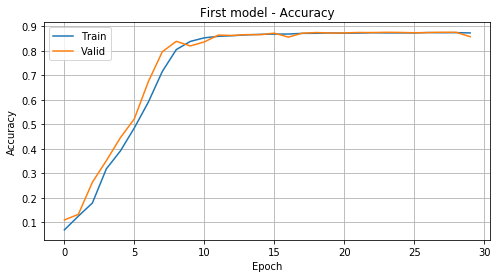

In [323]:
plot_curves(f'First model - Accuracy', [orig_model_1.history['acc_train'], orig_model_1.history['acc_valid']], 'Accuracy', 'Epoch', ['Train', 'Valid'])


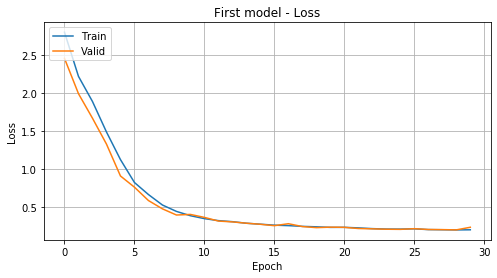

In [324]:
plot_curves(f'First model - Loss', [orig_model_1.history['loss_train'], orig_model_1.history['loss_valid']], 'Loss', 'Epoch', ['Train', 'Valid'])


# dat augmentation

In [325]:
aug_data_gen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)

aug_train_gen = aug_data_gen.flow(x=train_x, y=train_y, batch_size=BATCH_SIZE, shuffle=True)


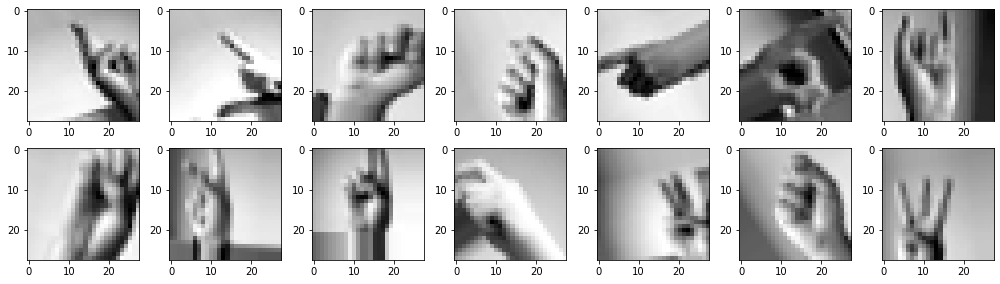

In [326]:
plt.figure(figsize=(14, 4))
for i in range(0, 14):
    plt.subplot(2, 7, i+1)
    X_batch, Y_batch = aug_train_gen.__getitem__(i)
    image = X_batch[0]
    plt.imshow(image.reshape(28,28), cmap='gray')
    
plt.tight_layout()
plt.show()

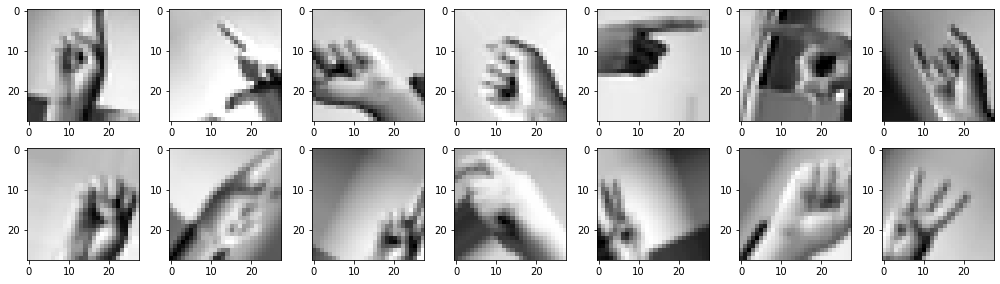

In [327]:
plt.figure(figsize=(14, 4))
for i in range(0, 14):
    plt.subplot(2, 7, i+1)
    X_batch, Y_batch = aug_train_gen.__getitem__(i)
    image = X_batch[0]
    plt.imshow(image.reshape(28,28), cmap='gray')
    
plt.tight_layout()
plt.show()

In [328]:
aug_model_1 = Model1(drop_out=0.5)
aug_model_1.fit_gen(aug_train_gen, o_valid_gen, epochs=EPOCH)

  0%|          | 0/364 [00:00<?, ?it/s]

object del
-----------------------------------------------------------------
Epochs: 30	| Iterations: 364	| Batch: 64
-----------------------------------------------------------------


  0%|          | 0/364 [00:00<?, ?it/s]

Epoch 1: (82.84536 s) 	 loss - Tr[3.17909] Va[3.17802] 	 acc - Tr[4.17%] Va[4.01%]
-----------------------------------------------------------------


  0%|          | 0/364 [00:00<?, ?it/s]

Epoch 2: (82.95340 s) 	 loss - Tr[3.17818] Va[3.17806] 	 acc - Tr[4.17%] Va[4.01%]
-----------------------------------------------------------------


  0%|          | 0/364 [00:00<?, ?it/s]

Epoch 3: (82.42188 s) 	 loss - Tr[3.17825] Va[3.17806] 	 acc - Tr[4.17%] Va[4.01%]
-----------------------------------------------------------------


  0%|          | 0/364 [00:00<?, ?it/s]

Epoch 4: (82.78624 s) 	 loss - Tr[3.17812] Va[3.17807] 	 acc - Tr[4.17%] Va[4.01%]
-----------------------------------------------------------------


  0%|          | 0/364 [00:00<?, ?it/s]

Epoch 5: (82.10299 s) 	 loss - Tr[3.17827] Va[3.17807] 	 acc - Tr[4.17%] Va[4.01%]
-----------------------------------------------------------------


  0%|          | 0/364 [00:00<?, ?it/s]

Epoch 6: (85.28303 s) 	 loss - Tr[3.17828] Va[3.17807] 	 acc - Tr[4.17%] Va[4.01%]
-----------------------------------------------------------------


  0%|          | 0/364 [00:00<?, ?it/s]

Epoch 7: (82.50509 s) 	 loss - Tr[3.17828] Va[3.17807] 	 acc - Tr[4.17%] Va[4.01%]
-----------------------------------------------------------------


  0%|          | 0/364 [00:00<?, ?it/s]

Epoch 8: (82.49366 s) 	 loss - Tr[3.17827] Va[3.17808] 	 acc - Tr[4.17%] Va[4.01%]
-----------------------------------------------------------------


  0%|          | 0/364 [00:00<?, ?it/s]

Epoch 9: (82.74896 s) 	 loss - Tr[3.17828] Va[3.17807] 	 acc - Tr[4.17%] Va[4.01%]
-----------------------------------------------------------------


  0%|          | 0/364 [00:00<?, ?it/s]

Epoch 10: (82.16025 s) 	 loss - Tr[3.17827] Va[3.17807] 	 acc - Tr[4.17%] Va[4.01%]
-----------------------------------------------------------------


  0%|          | 0/364 [00:00<?, ?it/s]

Epoch 11: (82.48239 s) 	 loss - Tr[3.17827] Va[3.17807] 	 acc - Tr[4.17%] Va[4.01%]
-----------------------------------------------------------------


  0%|          | 0/364 [00:00<?, ?it/s]

Epoch 12: (82.46260 s) 	 loss - Tr[3.17827] Va[3.17807] 	 acc - Tr[4.17%] Va[4.01%]
-----------------------------------------------------------------


  0%|          | 0/364 [00:00<?, ?it/s]

Epoch 13: (82.35193 s) 	 loss - Tr[3.17827] Va[3.17807] 	 acc - Tr[4.17%] Va[4.01%]
-----------------------------------------------------------------


  0%|          | 0/364 [00:00<?, ?it/s]

Epoch 14: (82.07580 s) 	 loss - Tr[3.17827] Va[3.17807] 	 acc - Tr[4.17%] Va[4.01%]
-----------------------------------------------------------------


  0%|          | 0/364 [00:00<?, ?it/s]

Epoch 15: (83.01693 s) 	 loss - Tr[3.17827] Va[3.17807] 	 acc - Tr[4.17%] Va[4.01%]
-----------------------------------------------------------------


Epoch: 17:   0%|          | 1/364 [00:00<01:11,  5.05it/s, acc=0.01%, loss=0.00873]

Epoch 16: (82.82612 s) 	 loss - Tr[3.17827] Va[3.17807] 	 acc - Tr[4.17%] Va[4.01%]
-----------------------------------------------------------------


Epoch: 18:   0%|          | 1/364 [00:00<01:07,  5.42it/s, acc=0.01%, loss=0.00873]

Epoch 17: (73.71064 s) 	 loss - Tr[3.17827] Va[3.17807] 	 acc - Tr[4.17%] Va[4.01%]
-----------------------------------------------------------------


Epoch: 19:   0%|          | 1/364 [00:00<01:05,  5.52it/s, acc=0.01%, loss=0.00873]

Epoch 18: (72.52914 s) 	 loss - Tr[3.17827] Va[3.17807] 	 acc - Tr[4.17%] Va[4.01%]
-----------------------------------------------------------------


Epoch: 20:   0%|          | 1/364 [00:00<01:06,  5.45it/s, acc=0.01%, loss=0.00873]

Epoch 19: (71.84036 s) 	 loss - Tr[3.17952] Va[3.17806] 	 acc - Tr[4.17%] Va[4.01%]
-----------------------------------------------------------------


Epoch: 21:   0%|          | 1/364 [00:00<01:10,  5.13it/s, acc=0.01%, loss=0.00873]

Epoch 20: (71.71104 s) 	 loss - Tr[3.17812] Va[3.17809] 	 acc - Tr[4.17%] Va[4.01%]
-----------------------------------------------------------------


  0%|          | 0/364 [00:00<?, ?it/s]

Epoch 21: (76.84342 s) 	 loss - Tr[3.17828] Va[3.17808] 	 acc - Tr[4.17%] Va[4.01%]
-----------------------------------------------------------------


Epoch: 23:   0%|          | 1/364 [00:00<01:07,  5.41it/s, acc=0.01%, loss=0.00873]

Epoch 22: (72.32183 s) 	 loss - Tr[3.17796] Va[3.17808] 	 acc - Tr[4.17%] Va[4.01%]
-----------------------------------------------------------------


Epoch: 24:   0%|          | 1/364 [00:00<01:06,  5.47it/s, acc=0.01%, loss=0.00873]

Epoch 23: (71.73722 s) 	 loss - Tr[3.17828] Va[3.17808] 	 acc - Tr[4.17%] Va[4.01%]
-----------------------------------------------------------------


Epoch: 25:   0%|          | 1/364 [00:00<01:05,  5.58it/s, acc=0.01%, loss=0.00873]

Epoch 24: (71.31717 s) 	 loss - Tr[3.17827] Va[3.17807] 	 acc - Tr[4.17%] Va[4.01%]
-----------------------------------------------------------------


  0%|          | 0/364 [00:00<?, ?it/s]

Epoch 25: (75.21633 s) 	 loss - Tr[3.17827] Va[3.17807] 	 acc - Tr[4.17%] Va[4.01%]
-----------------------------------------------------------------


Epoch: 27:   0%|          | 0/364 [00:00<?, ?it/s]

Epoch 26: (80.77842 s) 	 loss - Tr[3.17827] Va[3.17807] 	 acc - Tr[4.17%] Va[4.01%]
-----------------------------------------------------------------


Epoch: 28:   0%|          | 1/364 [00:00<01:02,  5.82it/s, acc=0.01%, loss=0.00873]

Epoch 27: (73.63806 s) 	 loss - Tr[3.17827] Va[3.17807] 	 acc - Tr[4.17%] Va[4.01%]
-----------------------------------------------------------------


Epoch: 28:  97%|█████████▋| 354/364 [01:26<00:02,  4.08it/s, acc=4.09%, loss=3.09094]


KeyboardInterrupt: 

In [ ]:
print_test('Aug model', aug_model_1)

In [ ]:
plot_curves(f'Aug model - Accuracy', [aug_model_1.history['acc_train'], aug_model_1.history['acc_valid']], 'Accuracy', 'Epoch', ['Train', 'Valid'])


In [ ]:
plot_curves(f'Aug model - Loss', [aug_model_1.history['loss_train'], aug_model_1.history['loss_valid']], 'Loss', 'Epoch', ['Train', 'Valid'])


# Transfer Learning

In [ ]:
import tensorflow.keras as keras
from PIL import Image

In [ ]:
def to_vgg16(data):
    rgb_data = np.repeat(data, 3, 3)
    padded_data = np.pad(rgb_data, ((0,0),(2,2),(2,2),(0,0)), 'constant')
    return padded_data

In [ ]:
train_x_32 = to_vgg16(train_x)
valid_x_32 = to_vgg16(valid_x)
test_x_32 = to_vgg16(test_x)

o_data_gen_3 = ImageDataGenerator(rescale=1.0/255.0,)

o_train_gen_3 = o_data_gen_3.flow(x=train_x_32, y=train_y, batch_size=BATCH_SIZE, shuffle=True)
o_valid_gen_3 = o_data_gen_3.flow(x=valid_x_32, y=valid_y, batch_size=VALID_BATCH_SIZE, shuffle=True)
o_test_gen_3 = o_data_gen_3.flow(x=test_x_32, y=test_y, batch_size=VALID_BATCH_SIZE, shuffle=True)

aug_data_gen_3 = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)

aug_train_gen_3 = aug_data_gen_3.flow(x=train_x_32, y=train_y, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
plt.imshow(o_train_gen_3.next()[0][0])

In [ ]:
def get_vgg16_model():
    vgg16 = keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
    vgg16.trainable = True
    trainable = False
    for layer in vgg16.layers:
        if layer.name == 'block5_conv1':
            trainable = True
        layer.trainable = trainable

    model = keras.Sequential()

    model.add(vgg16)
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(128, activation='relu'))
    model.add(keras.layers.Dropout(0.5))
    model.add(keras.layers.Dense(128, activation='relu'))
    model.add(keras.layers.Dropout(0.5))
    model.add(keras.layers.Dense(OUTPUT, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer=keras.optimizers.Adam(lr=1e-5), 
                  metrics=['accuracy'])
    return model

In [ ]:
tr_l_model = get_vgg16_model()

In [ ]:
tr_l_model.summary()

In [ ]:
tr_l_model.fit_generator(
    o_train_gen_3,
    steps_per_epoch=len(o_train_gen_3),
    epochs=TR_LAERN_EPOCH,
    validation_data=o_valid_gen_3,
    validation_steps=len(o_valid_gen_3)
)

In [ ]:
tr_l_loss, tr_l_acc = tr_l_model.evaluate_generator(o_test_gen_3, steps=len(o_test_gen_3))
tr_l_loss, tr_l_acc

In [ ]:
print(f'Transfer Learning vgg16: loss - {tr_l_loss:.4f}\t Acc - {tr_l_acc:.02%}')

In [ ]:
plot_curves(f'TR Learning model - Accuracy', [tr_l_model.history.history['acc'], tr_l_model.history.history['val_acc']], 'Accuracy', 'Epoch', ['Train', 'Valid'])


In [ ]:
plot_curves(f'TR Learning model - Loss', [tr_l_model.history.history['loss'], tr_l_model.history.history['val_loss']], 'Loss', 'Epoch', ['Train', 'Valid'])


In [ ]:
tr_l_model_aug = get_vgg16_model()
tr_l_model_aug.fit_generator(
    aug_train_gen_3,
    steps_per_epoch=len(aug_train_gen_3),
    epochs=TR_LAERN_EPOCH,
    validation_data=o_valid_gen_3,
    validation_steps=len(o_valid_gen_3)
)

tr_l_loss_aug, tr_l_acc_aug = tr_l_model_aug.evaluate_generator(o_test_gen_3, steps=len(o_test_gen_3))
tr_l_loss_aug, tr_l_acc_aug

In [ ]:
print(f'Transfer Learning vgg16: loss - {tr_l_loss_aug:.4f}\t Acc - {tr_l_acc_aug:.02%}')

In [ ]:
plot_curves(f'TR Learning model (aug) - Accuracy', [tr_l_model_aug.history.history['acc'], tr_l_model_aug.history.history['val_acc']], 'Accuracy', 'Epoch', ['Train', 'Valid'])


In [ ]:
plot_curves(f'TR Learning model (aug) - Loss', [tr_l_model_aug.history.history['loss'], tr_l_model_aug.history.history['val_loss']], 'Loss', 'Epoch', ['Train', 'Valid'])


In [ ]:
_, aug_test_acc = aug_model_1.evaluate_gen(o_test_gen)

In [ ]:
_, orig_test_acc = orig_model_1.evaluate_gen(o_test_gen)

In [ ]:
labels = ['Original', 'Aug', 'VGG16_Or', 'VGG16_aug']
test_acc = [orig_test_acc, aug_test_acc, tr_l_acc, tr_l_acc_aug]

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(labels,test_acc, color=['Blue', 'Orange', 'Green'])
plt.ylim(0.8, 0.99)
plt.show()